# RNN Training

### Welcome!


In this notebook you can train an LSTM or GRU network on any language you like.
It is part of the ICML 2018 paper, [Extracting Automata from Recurrent Neural Networks Using Queries and Counterexamples](https://arxiv.org/abs/1711.09576) by Weiss et al..

#### Quick Start
The easiest way to start is to just "run all". This notebook will train and extract an LSTM network on the 3rd Tomita grammar (it tends to learn that one pretty easily, and it's more interesting than the first or second grammars). But you can also do your own thing: we import implementations of all the Tomita grammars here, and you can ask it to learn any one of those instead. (Tomitas 1-4 and 7 generally train pretty easily. Tomitas 5 and 6 are more difficult...)

You can also define any other language you like, including over other alphabets. For that, just set the `target` and `alphabet` variables. 

Other than that, the different things going on in this notebok are explained if you browse through it. 


# Code starts here!

### 1. Imports

Implementations of LSTM and GRU classifiers, the Tomita grammars, and our main extraction method.

In [1]:
from LSTM import LSTMNetwork
from GRU import GRUNetwork
from RNNClassifier import RNNClassifier
from Training_Functions import make_train_set_for_target,mixed_curriculum_train
from Tomita_Grammars import tomita_1, tomita_2, tomita_3, tomita_4, tomita_5, tomita_6, tomita_7

ModuleNotFoundError: No module named 'dynet'

### 2. Training

#### 2.1. Define a Language
Define a target language for your network. 

A language is defined as a function that takes a word over a fixed alphabet and either accepts or rejects it.

You can pick any one of the Tomita grammars we have imported, they are defined over the alphabet $\{0,1\}$.

You can also define your own target language. For instance, the language of all words starting and ending with the same character, over the alphabet $\{a,b,c\}$:

```
def target(w):             
   if len(w)==0:          
       return True         
   return w[0]==w[-1] 

alphabet = "abc"    
```

In [4]:

target = tomita_3
alphabet = "abc"

The tomita_3 language is the complement of `((0|1)*0)*1(11)*(0(0|1)*1)*0(00)*(1(0|1)*)*` (i.e., the language of all words where there is no odd number of consecutive zeros after an odd number of consecutive ones),
as verified below.

In [10]:
print(target("01101"))
print(target("111000"))
print(target("0001010"))

False
True
False


#### 2.2. Create a Train Set
`make_train_set_for_target` returns for the target function a dictionary of words of different lengths, each mapped to its classification by the target. It tries to return a train set with an even split between positive and negative samples for each sample length. Its optional parameters are:
>1. `max_train_samples_per_length` (default 300): the maximum number of words of each length in the train set
>2. `search_size_per_length` (default 1000): the maximum number of words to be sampled from each length while generating the train set
>3. `provided_examples` (default `None`): hand-crafted samples to add to the train set (helpful if random sampling is unlikely to find one of the classes)
>4. `lengths` (a list of integers, default $0-15,20,25,30$): the lengths that will appear in the train set

If the target is such that the positive or negative class is relatively rare, `make_train_set_for_target` is unlikely to create an evenly split test set without some help. In this case it is best to help it with some provided examples, e.g.: for the language of all words containing the sequence `0123` over the alphabet $\{0,1,2,3\}$, you may want to run:
```
short_strings = ["","0","1","2","3"]
positive_examples = [a+"0123"+b for a,b in itertools.product(short_strings,short_strings)]
make_train_set_for_target(target,alphabet,provided_examples=positive_examples)
```


In [11]:
train_set = make_train_set_for_target(target,alphabet)

made train set of size: 539 , of which positive examples: 104


In [12]:
print(len(train_set))
print(list(train_set.items())[:10])

539
[('', False), ('b', False), ('a', False), ('c', False), ('bc', True), ('cb', False), ('bb', False), ('ac', False), ('cc', False), ('ca', False)]


#### 2.3. Create and Train a Network


`RNNClassifier` generates an RNN-Classifier for a given alphabet.
Its optional parameters are:
>1. `num_layers` (default value 2): the number of hidden layers
>2. `hidden_dim` (default value 5): the size of the hidden layers
>3. `input_dim` (default value 3): the size of the input vectors 
>4. `RNNClass` (default value `LSTMNetwork`): the RNN architecture (possible values `LSTMNetwork`, `GRUNetwork`)

In [13]:
rnn = RNNClassifier(alphabet,num_layers=1,hidden_dim=10,RNNClass = LSTMNetwork)

The function `mixed_curriculum_train(rnn,train_set)` trains the network `rnn` with the given dictionary of labeled examples, `train_set`. Its optional parameters are: 
>1. `stop_threshold` (default $0.001$): the threshold for the average loss of the network on the train set under which training is cut short
>2. `learning_rate` (defualt 0.001): learning rate for optimiser
>2. `length_epochs` (default $5$): explained below
>3. `random_batch_epochs` (default $100$): below
>4. `random_batch_size` (default $20$): below
>5. `single_batch_epochs` (default $100$): below
>6. `outer_loops` (default $3$): below

`mixed_curriculum_train` splits the input dictionary first into batches by length, training for `length_epochs` iterations each of these batches, by order of increasing length. Then for `random_batch_epochs` iterations it will, at each iteration, split the dictionary into random batches of size `random_batch_size` and train each batch for one iteration. After that it will train the dictionary as one big batch for `single_batch_epochs` iterations. It does all of this `outer_loops` times.

This will print some scatter plots of the average loss on the train set. The plots will come in pairs: each time one for the most recent iterations of training where the whole dictionary was trained as one batch, and another for all the iterations the rnn has been trained since its initialisation.

`mixed_curriculum_train` should work for most simple targets without any tinkering. If the network doesn't drop under the stop threshold, you may want to call it again.

current average loss is:  0.4010491124370642
current average loss is:  0.3347735992416769
current average loss is:  0.2151282211377142
current average loss is:  0.09852420289730235
current average loss is:  0.05237206466365278


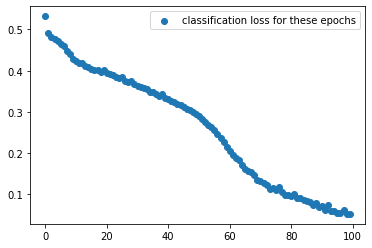

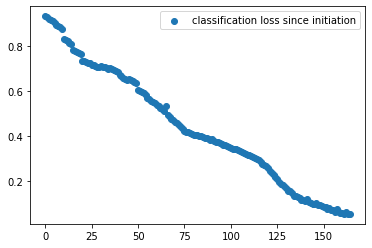

current average loss is:  0.041057738833170876
current average loss is:  0.03528725901870869
current average loss is:  0.02914436672967971
current average loss is:  0.023818732634988477
current average loss is:  0.019347967597239536


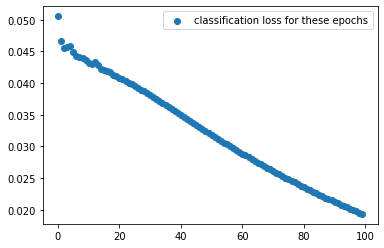

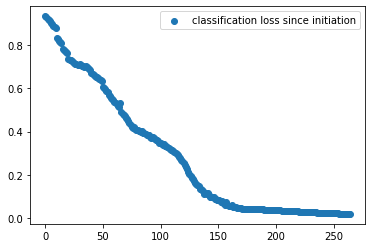

current average loss is:  0.006529717737732575
current average loss is:  0.002860969255249911
current average loss is:  0.0016198277371614667
current average loss is:  0.0010138194052094944
current average loss is:  0.0006854200983155867


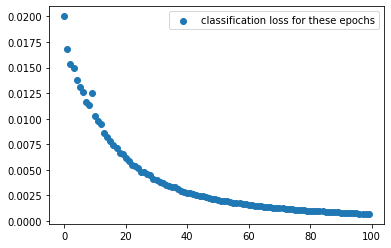

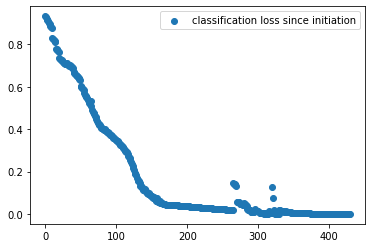

current average loss is:  0.000548831607061326


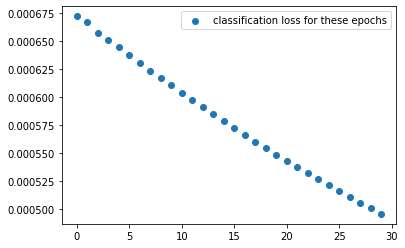

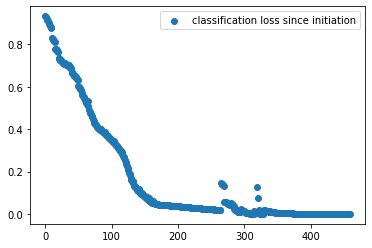

classification loss on last batch was: 0.0004958879195692809


In [14]:
mixed_curriculum_train(rnn,train_set,stop_threshold = 0.0005)